# Face Matching with Singular Value Decomposition
**Notebook by Group 12**

In this notebook, we have implemented a barebones algorithm for face matching by finding a single representation of several images of a subject using Singular Value Decomposition.  

In [6]:
# File handling
import os
import cv2
from glob import glob

# Visualization 
from matplotlib import pyplot as plt
import seaborn as sns

# Matrix operations
from numpy import (array, asarray, dot, vstack,
                   identity, mean, argmin)
from numpy.linalg import svd, norm

## Reading in images
Here, images are stored in a dictionary (keyed with subject ID) for further processing.

In [7]:
# Read images for each subject into a dictionary
# Indexed by folder number

im_dict = {}
all_images = []
labels = []

filepath = '.././data/data1' 
for num in os.listdir(filepath):
    images = []
    for path in glob(filepath+'/'+num+'/*.pgm'):
        img = cv2.imread(path, 0)
        images.append(img)
        all_images.append(img)
        labels.append(int(num))
    images = asarray(images)
    im_dict.update({num: images})

## Functions
Some functions have been defined below, which will be called later for performing the task. Here is a description of each function.

1. `flatten`: Each image is a 2 dimensional array (1 channel). We cannot perform SVD on a group of matrices, so we convert each image into a vector by flattening it. Each flattened image is stacked vertically, giving us 15 stacks (one for each subject).

2. `decompose_recreate`: Performs SVD on the stacks obtained from the previous function and reconstructs the stack using top `n_components` components. The reconstruction is performed using the relation below.

$$
A = U S V^{T}
$$

3. `compress`: Aggregates the reconstructed stack by either a usual average or a weighted average, if weights are specified.

In [8]:
# Some functions

def flatten(data):
    base = data[0].flatten()
    for i in range(1, len(data)):
        base = vstack((base, data[i].flatten()))
    return base

def decompose_recreate(data, n_components):
    k = n_components
    U, S, V = svd(data)
    sigma = S[:k]*identity(S[:k].shape[0])
    u_comps, v_comps = U[:, :k], V[:k, :]
    rec = dot(u_comps, dot(sigma, v_comps))
    return rec

def compress(data, weights=None):
    if weights is not None:
        try:
            weights.reshape(data.shape[0], 1)
        except:
            raise ValueError('Incorrect shape {} of weights'.format(asarray(weights.shape)))
        return mean(weights*data, axis=0)
    else:
        return mean(data, axis=0)

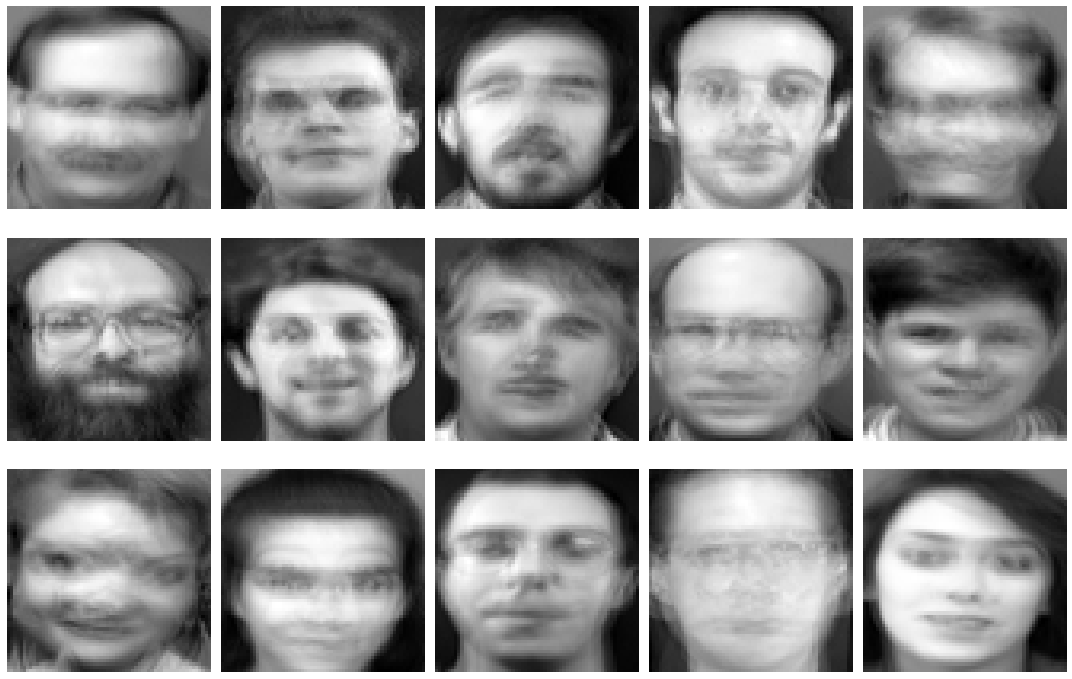

In [9]:
# Now we call the functions in sequence and 
# display the reconstructed, collapsed representations 

fig = plt.figure(figsize=(15, 10))
dict_keys = list(im_dict.keys())
rep_dict = {}

for i in range(len(dict_keys)):
    
    fig.add_subplot(3, 5, i+1)
    
    # Extract all images for this subject
    data = im_dict[dict_keys[i]]
    
    # Flatten to (10, 4096)
    flat = flatten(data)
    
    # Perform SVD and regenerate in fewer dimensions
    rec = decompose_recreate(flat, n_components=1)
    
    # New representation is mean of regenerated images
    comp = compress(rec)
    rep_dict.update({dict_keys[i]: comp.reshape(64, 64)})
    
    # Display representation
    plt.imshow(comp.reshape(64, 64), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Classification
We now find the euclidean distance (using Frobenius norm) of each image from each of the representative images, and define the one with least distance as that image's class. Based on that, the classification accuracy is **99.33%**.

In [10]:
# Check classification accuracy

def predict_class(img):
    min_idx = argmin([norm(img - rep) for rep in list(rep_dict.values())])
    return int(list(rep_dict.keys())[min_idx])

def accuracy_score(labels, predictions):
    return mean(array(labels) == array(predictions))

classes = []
for img in all_images:
    classes.append(predict_class(img))
    
print("Classification accuracy: {:.4f}".format(100.0 * accuracy_score(labels, classes)))

Classification accuracy: 99.3333


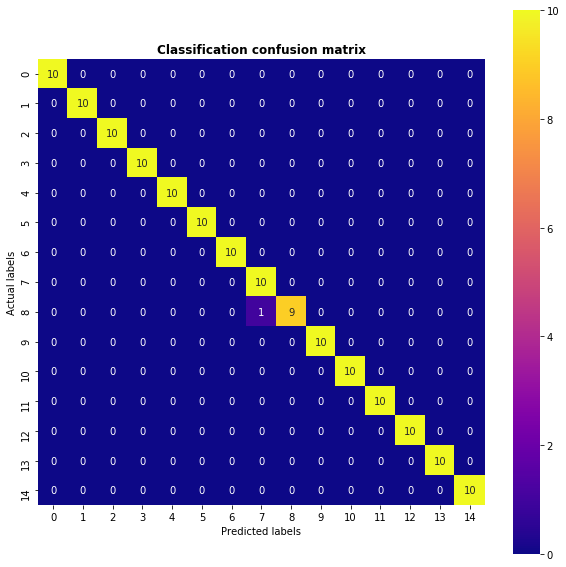

In [22]:
# Confusion matrix of the classifier

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, cmap='plasma')
plt.title('Classification confusion matrix', fontweight='bold')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()